# Exemplar Answer Generation Project - OpenAI Integration Section

This notebook preprocesses the training data, formats the data, integrates OpenAI API, and lastly evaluate the results.

## Environment Setup and Dependency Import

Aimed to assist the later dependencies import in the project. Several libraries and modules will be imported throughout the code for various tasks such as data manipulation, preprocessing, OpenAI API integration, and evaluation.

In [3]:
! pip install numpy scikit-learn openai tiktoken nltk sentence-transformers

# Section 1: Training Data Retrieval

In [4]:
# Dependency Imports for section 1

import json
from collections import Counter
from statistics import mean
from sklearn.model_selection import train_test_split

## 1.1 DataSet Processing

### 1.1.1 Data Loading

In [5]:
# Load the training data
with open('data/cura-llm-training-data.json', 'r') as file:
    training_data = json.load(file)
    
    print(f"Loaded {len(training_data)} training samples")

Loaded 117 training samples


### 1.1.2 Data Preprocessing and Preparation

We'll first preprocess our data to clean and standardize it, then format it for the OpenAI API.

In [6]:
# Preprocess a single data item
def preprocess_data(data_item):
    
    processed = {}
    
    # 1. Clean and truncate task content
    task_content = data_item['task_content']
    
    # Remove HTML entities
    task_content = task_content.replace('&nbsp;', ' ')
    
    # Truncate if too long (keeping most relevant parts)
    if len(task_content) > 11000:
        task_content = task_content[:11000]
    
    processed['task_content'] = task_content
    
    # 2. Format question
    processed['question'] = data_item['question'].strip()
    
    # 3. Process rubric
    rubric = json.loads(data_item['rubric'])
    
    # Normalize scoring criteria
    processed['rubric'] = {
        'criteria': rubric['criteria'],
        'total_score': int(rubric['total_score']),
        'items': [item.strip() for item in rubric['items']]
    }
    
    # 4. Clean exemplar answer
    answer = data_item['answer']
    
    # Remove extra quotes
    answer = answer.strip('"')
    
    # Remove multiple spaces
    answer = ' '.join(answer.split())
    processed['answer'] = answer
    
    return processed

In [7]:
# Process all data items
processed_data = []

for item in training_data:
    try:
        processed = preprocess_data(item)
        processed_data.append(processed)
    except Exception as e:
        print(f"Error processing item: {e}")
    continue

print(f"Successfully preprocessed {len(processed_data)} items")

Successfully preprocessed 117 items


In [8]:
# Verify preprocessing results
example_item = processed_data[0]
print("Example of preprocessed item:")
print(json.dumps(example_item, indent=2))

# Calculate preprocessing statistics
preprocessed_stats = {
    'task_content_lengths': [len(item['task_content']) for item in processed_data],
    'question_lengths': [len(item['question']) for item in processed_data],
    'answer_lengths': [len(item['answer']) for item in processed_data]
    }

print("\nPreprocessing Statistics:")
for key, values in preprocessed_stats.items():
    print(f"\n{key}:")
    print(f"  Mean: {mean(values):.2f}")
    print(f"  Max: {max(values)}")

Example of preprocessed item:
{
  "task_content": "Designing your rocket    Building phase     The shape, weight, and size of a rocket, and it\u2019s design of nose cone and fins, all affect how aerodynamic or efficient it will be.     Being efficient allows a rocket to use less fuel while travelling long distances or overcoming gravity to take off and escape our atmosphere.     Rockets need to go straight up when launching and not veer to one side or roll when travelling through space. An effective  nose cone  and  fins  will help to stabilise your rocket.     So, to create a rocket that can be launched into space, you must design:     A rocket body    Fins &amp; a nose cone    A final rocket design with all elements     In your teams, you must:     Design your nose cones and fins/tail. Think about which materials to use and how to attach them before constructing their designs    Two team members could construct the nose cone and the other two could construct the fins/tail design. You

### 1.1.3 Format Data for OpenAI API

In [9]:
# Format preprocessed data for OpenAI API training
def prepare_training_format(processed_data):
    
    formatted_data = []
    
    for item in processed_data:
        formatted_item = {
            'context': {
                'task_content': item['task_content'],
                'rubric': item['rubric'],
                'question': item['question']
            },
            'exemplar_answer': item['answer']
            }
        formatted_data.append(formatted_item)
    
    return formatted_data
        
# Format the preprocessed data
formatted_data = prepare_training_format(processed_data)
print("Example of formatted training data:")
print(json.dumps(formatted_data[0], indent=2))

Example of formatted training data:
{
  "context": {
    "task_content": "Designing your rocket    Building phase     The shape, weight, and size of a rocket, and it\u2019s design of nose cone and fins, all affect how aerodynamic or efficient it will be.     Being efficient allows a rocket to use less fuel while travelling long distances or overcoming gravity to take off and escape our atmosphere.     Rockets need to go straight up when launching and not veer to one side or roll when travelling through space. An effective  nose cone  and  fins  will help to stabilise your rocket.     So, to create a rocket that can be launched into space, you must design:     A rocket body    Fins &amp; a nose cone    A final rocket design with all elements     In your teams, you must:     Design your nose cones and fins/tail. Think about which materials to use and how to attach them before constructing their designs    Two team members could construct the nose cone and the other two could construct th

### 1.1.4 Split Data for Training and Validation

In [10]:
# Split data into training and validation sets
train_data, val_data = train_test_split(formatted_data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Save processed and split data
with open('data/processed_train_data.json', 'w') as f:
    json.dump(train_data, f, indent=2)

with open('data/processed_val_data.json', 'w') as f:
   json.dump(val_data, f, indent=2)

print("Saved processed training and validation data")

Training set size: 93
Validation set size: 24
Saved processed training and validation data


# Section 2: OpenAI API Integration

In [11]:
# Dependency Imports for Section 2

import os
import tiktoken
import time
import logging
import nltk
import numpy as np
import pandas as pd
from openai import OpenAI
from typing import Dict, List, Optional
from sklearn.model_selection import KFold
from sentence_transformers import SentenceTransformer


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Set up API key
OPENAI_API_KEY = "sk-svcacct-uPxqiJzaSiREXSBYOcwrhvmpYLe3uGPMjs6eQ_XELvLftEZ3Ti59ubhaZgPK3Uc0fTU6vevKT3BlbkFJMHPKGyXsJKAVw2CavL0utPanw92cweyJzkuIe4e5v5dtqF803SAACEsEsHfZQnyNWbG-cgUA"

e:\Software\Anaconda\envs\CuraProjectFinal\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ABC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ABC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 2.1 Set Up OpeaAI Handler

### 2.1.1 Base OpenAI Handler

In [12]:
class BaseOpenAIHandler:
    def __init__(self, api_key: str, model: str = "gpt-4o-mini"):
        self.client = OpenAI(api_key=api_key)
        self.model = model
        self.encoding = tiktoken.get_encoding("cl100k_base")
        self.total_tokens_used = 0
        self.token_limit = 5_000_000
        
        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        
        # Initialize token counter file
        os.makedirs('outputs', exist_ok=True)
        self._init_token_counter()
    
    def _init_token_counter(self):
        """Initialize or load token counter from file"""
        try:
            with open('outputs/token_usage.json', 'r') as f:
                usage_data = json.load(f)
                self.total_tokens_used = usage_data.get('total_tokens', 0)
        except FileNotFoundError:
            self._save_token_usage()
    
    def _save_token_usage(self):
        """Save token usage to file"""
        with open('outputs/token_usage.json', 'w') as f:
            json.dump({'total_tokens': self.total_tokens_used}, f)
    
    def count_tokens(self, text: str) -> int:
        """Count tokens in a text string"""
        return len(self.encoding.encode(text))
    
    def get_token_usage_stats(self) -> Dict:
        """Get current token usage statistics"""
        return {
            'total_tokens_used': self.total_tokens_used,
            'remaining_tokens': self.token_limit - self.total_tokens_used,
            'percentage_used': (self.total_tokens_used / self.token_limit) * 100
        }

### 2.1.2 OpenAI Prompt Handler

In [13]:
class PromptHandler(BaseOpenAIHandler):
    def __init__(self, api_key: str, model: str = "gpt-4o-mini"):
        super().__init__(api_key, model)
        self.prompt_template = None
        
    def format_prompt(self, context: Dict) -> str:
        """Basic prompt format"""
        prompt = f"""Given a teaching context, generate a high-quality exemplar answer.

Task Content:
{context['task_content']}

Question:
{context['question']}

Rubric Criteria:
- Total Score: {context['rubric']['total_score']}
- Assessment Criteria: {context['rubric']['criteria']}
- Scoring Items:
{chr(10).join([f"  {i+1}. {item}" for i, item in enumerate(context['rubric']['items'])])}

Generate an exemplar answer that:
1. Directly addresses the question
2. Meets the highest scoring criteria in the rubric
3. Demonstrates clear understanding and comprehensive coverage
4. Uses appropriate academic language
5. Is concise yet complete

Exemplar Answer:"""
        return prompt
    
    def _create_basic_template(self, context: Dict) -> str:
        """Basic Prompt Template"""
        return self.format_prompt(context)
    
    def _create_few_shot_template(self, context: Dict) -> str:
        """Template with few-shot examples"""
        examples = "\n\n".join([
            f"Example {i+1}:\n"
            f"Question: {ex['question']}\n"
            f"Rubric: {ex['rubric']}\n"
            f"Answer: {ex['answer']}\n"
            for i, ex in enumerate(self.best_examples)
        ])
        
        prompt = f"""Given a teaching context, generate a high-quality exemplar answer.

Previous successful examples:
{examples}

Now, generate an answer for:
Task Content:
{context['task_content']}

Question:
{context['question']}

Rubric Criteria:
- Total Score: {context['rubric']['total_score']}
- Assessment Criteria: {context['rubric']['criteria']}
- Scoring Items:
{chr(10).join([f"  {i+1}. {item}" for i, item in enumerate(context['rubric']['items'])])}

Generate an exemplar answer that:
1. Directly addresses the question
2. Meets the highest scoring criteria in the rubric
3. Demonstrates clear understanding and comprehensive coverage
4. Uses appropriate academic language
5. Is concise yet complete

Exemplar Answer:"""
        return prompt
    
    def _create_detailed_template(self, context: Dict) -> str:
        """Prompt template with detailed instructions"""
        rubric_items = context['rubric']['items']
        highest_score_criteria = rubric_items[0]
        
        prompt = f"""As an expert education content creator, generate a high-quality exemplar answer.

Task Context:
{context['task_content']}

Question to Answer:
{context['question']}

To achieve the highest score ({context['rubric']['total_score']} points), your answer must:
- Meet this specific criteria: {highest_score_criteria}
- Demonstrate deep understanding of: {context['rubric']['criteria']}
- Include clear evidence and explanation
- Use precise academic language
- Be well-structured and coherent

Scoring Guide:
{chr(10).join([f"Level {i+1}: {item}" for i, item in enumerate(rubric_items)])}

Additional Requirements:
1. Start with a clear main point
2. Support with specific evidence
3. Explain relationships between concepts
4. Use subject-specific vocabulary
5. Conclude with a summary if appropriate

Your Exemplar Answer:"""
        return prompt

### 2.1.3 OpenAI Generation Handler

In [14]:
class GenerationHandler(PromptHandler):
          
    def generate_answer(self, context: Dict, 
                       max_retries: int = 3, 
                       temperature: float = 0.7) -> Optional[str]:
        
        """Generate answer with optimized prompt"""
        if self.prompt_template:
            prompt = self.prompt_template(context)
        else:
            prompt = self.format_prompt(context)
            
        prompt_tokens = self.count_tokens(prompt)
        
        if self.total_tokens_used + prompt_tokens > self.token_limit:
            self.logger.error("Token limit reached!")
            return None
        
        for attempt in range(max_retries):
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": "You are an expert education content creator specializing in generating exemplar answers for student assessment."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=temperature,
                    max_tokens=1000
                )
                
                self.total_tokens_used += response.usage.total_tokens
                self._save_token_usage()
                
                return response.choices[0].message.content
                
            except Exception as e:
                self.logger.error(f"Attempt {attempt + 1} failed: {str(e)}")
                if attempt == max_retries - 1:
                    raise
                time.sleep(2 ** attempt)
             
    def estimate_prompt_tokens(self, context: Dict) -> int:
        """Estimate tokens for a prompt before sending"""
        formatted_prompt = self.format_prompt(context)
        return self.count_tokens(formatted_prompt)

### 2.1.4 OpenAI Training Handler

In [41]:
class TrainingHandler(GenerationHandler):
    
    def optimize_prompt_template(self, validation_data: List[Dict]):
        """Optimise prompt templates"""
        templates = [
            self._create_basic_template,
            self._create_few_shot_template,
            self._create_detailed_template
        ]
        
        best_score = 0
        best_template = None
        
        for template_func in templates:
            score = self._evaluate_template(template_func, validation_data)
            if score > best_score:
                best_score = score
                best_template = template_func
        
        self.prompt_template = best_template
        self.logger.info(f"Selected best template with score: {best_score}")
    
    def _evaluate_template(self, template_func, validation_data: List[Dict]) -> float:
        """Evaluating the effectiveness of prompt templates"""
        scores = []
        for item in validation_data[:5]:
            try:
                prompt = template_func(item['context'])
                generated_answer = self.generate_answer(item['context'], temperature=0.3)
                if generated_answer:
                    quality_score = self._evaluate_example_quality({
                        'answer': generated_answer,
                        'rubric': json.dumps(item['context']['rubric']),
                        'question': item['context']['question']
                    })
                    scores.append(quality_score)
            except Exception as e:
                self.logger.error(f"Template evaluation error: {e}")
                continue
        
        return np.mean(scores) if scores else 0.0
    
    def _evaluate_example_quality(self, example: Dict) -> float:
        """Example quality assessment"""
        score = 0.0
        answer = example['answer']
        rubric = example['rubric']
        rubric_data = json.loads(rubric)
        
        # 1. Content relevance (0.5 points)
        rubric_items = rubric_data['items']
        criteria = rubric_data['criteria'].lower()
        answer_lower = answer.lower()
        
        # Check for keyword matching
        keyword_matches = sum(1 for item in rubric_items if item.lower() in answer_lower)
        content_score = min(0.4, (keyword_matches / len(rubric_items)) * 0.5)
        score += content_score
        
        # Completeness of answer (0.2 marks)
        # Adjustment of desired length based on total score, 50 words per score
        expected_length = int(rubric_data['total_score']) * 50
        actual_length = len(answer)
        if actual_length >= expected_length:
            score += 0.3
        else:
            score += 0.3 * (actual_length / expected_length)
        
        # 3. Language quality (0.3 points)
        sentences = [s.strip() for s in answer.split('.') if s.strip()]
        
        # Sentence count scoring
        if len(sentences) >= 2:
            score += 0.1
        
        # Lexical diversity
        words = answer.split()
        unique_words = set(words)
        vocabulary_ratio = len(unique_words) / len(words) if words else 0
        if vocabulary_ratio >= 0.6:  # Lexical richness thresholds
            score += 0.1
        
        domain_terms = self._get_domain_terms(criteria)
        term_usage = sum(1 for term in domain_terms if term in answer_lower)
        if term_usage >= 2:
            score += 0.1
        
        return score
    
    def _get_domain_terms(self, criteria: str) -> List[str]:
        """Identify domain terms based on scoring criteria"""
        
        science_terms = ['hypothesis', 'experiment', 'evidence', 'observation', 'analysis', 
                        'data', 'conclusion', 'theory', 'method', 'result']
        math_terms = ['equation', 'calculate', 'solve', 'formula', 'proof', 
                    'measurement', 'ratio', 'proportion', 'value']
        
        if 'scientifically' in criteria:
            return science_terms
        elif 'mathematical' in criteria:
            return math_terms
        
        return science_terms + math_terms 

    def select_best_examples(self, training_data: List[Dict], n_examples: int = 3):
        """Select the best few-shot example"""
        selected_examples = []
        for item in training_data:
            
            example = {
                'answer': item['exemplar_answer'],
                'rubric': json.dumps(item['context']['rubric']),
                'question': item['context']['question']
            }
            # Assessing quality
            quality_score = self._evaluate_example_quality(example)
            example['quality_score'] = quality_score
            selected_examples.append(example)
        
        # Sort and select the best examples
        selected_examples.sort(key=lambda x: x['quality_score'], reverse=True)
        self.best_examples = selected_examples[:n_examples]
        
        # Save the best examples
        with open('outputs/best_examples.json', 'w') as f:
            json.dump(self.best_examples, f, indent=2)
            
    def train(self, training_data: List[Dict], validation_data: List[Dict]):
            """Training process"""
            self.logger.info("Starting training process...")
            
            #  Select the best example
            self.logger.info("Selecting best examples...")
            self.select_best_examples(training_data)
            
            # Optimise the prompt template
            self.logger.info("Optimizing prompt template...")
            self.optimize_prompt_template(validation_data)
            
            # Save the training results
            self.logger.info("Saving training results...")
            self._save_training_results()
            
            self.logger.info("Training completed!")
    
    def _save_training_results(self):
        """Save training results to file"""
        
        results = {
            'best_examples': self.best_examples,
            'selected_template': self.prompt_template.__name__,
            'token_usage': self.get_token_usage_stats()
        }
        
        with open('outputs/training_results.json', 'w') as f:
            json.dump(results, f, indent=2)

### 2.1.5 OpenAI Evaluation Handler (For Section 3: Exemplar Answer Quality Evaluation)

In [42]:
class EvaluationHandler(TrainingHandler):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        
    def _calculate_rubric_alignment(self, answer: str, rubric: Dict) -> float:
        """Evaluate the alignment between answer and rubric criteria"""
        alignment_score = 0.0
        
        # Check if each scoring criterion is met
        items = rubric['items']
        total_score = float(rubric['total_score'])
        
        # Convert answer to lowercase for comparison
        answer_lower = answer.lower()
        
        # Calculate matching degree for each scoring item
        matches = []
        for item in items:
            item_lower = item.lower()
            
            # Check if keywords appear in the answer
            keywords = item_lower.split()
            keyword_matches = sum(1 for word in keywords if word in answer_lower)
            match_ratio = keyword_matches / len(keywords)
            matches.append(match_ratio)
        
        # Calculate overall alignment score
        if matches:
            # Give higher weight to higher-scoring criteria
            weights = [1.0 - (i / len(matches)) for i in range(len(matches))]
            alignment_score = sum(m * w for m, w in zip(matches, weights)) / sum(weights)
            
        return alignment_score

    def _calculate_semantic_similarity(self, generated: str, reference: str) -> float:
        """Calculate semantic similarity"""
        try:
            # Use Sentence-BERT to calculate semantic similarity
            generated_embedding = self.sentence_model.encode([generated])[0]
            reference_embedding = self.sentence_model.encode([reference])[0]
            
            # Calculate cosine similarity
            similarity = np.dot(generated_embedding, reference_embedding) / \
                        (np.linalg.norm(generated_embedding) * np.linalg.norm(reference_embedding))
            
            return float(similarity)
        except Exception as e:
            self.logger.warning(f"Error calculating semantic similarity: {e}")
            return 0.0

    def _extract_keywords(self, text: str) -> List[str]:
        """Extract keywords from text"""
        # Use nltk for POS tagging and keyword extraction
        try:
            # Tokenization
            tokens = nltk.word_tokenize(text)
            # POS tagging
            tagged = nltk.pos_tag(tokens)
            
            # Extract nouns, verbs, and adjectives as keywords
            keywords = [word for word, pos in tagged 
                    if pos.startswith(('NN', 'VB', 'JJ')) 
                    and len(word) > 2]  # Filter out too short words
            
            # Remove duplicates
            keywords = list(set(keywords))
            return keywords
        except Exception as e:
            self.logger.warning(f"Error in keyword extraction: {e}")
            return []

    def _compare_answer_structure(self, generated: str, reference: str) -> float:
        """Compare structural similarity between answers"""
        try:
            # 1. Split text into paragraphs
            gen_paragraphs = generated.split('\n\n')
            ref_paragraphs = reference.split('\n\n')
            
            # 2. Calculate similarity in paragraph count
            para_ratio = min(len(gen_paragraphs), len(ref_paragraphs)) / max(len(gen_paragraphs), len(ref_paragraphs))
            
            # 3. Calculate similarity in sentence length distribution
            gen_sentences = nltk.sent_tokenize(generated)
            ref_sentences = nltk.sent_tokenize(reference)
            
            gen_lengths = [len(s.split()) for s in gen_sentences]
            ref_lengths = [len(s.split()) for s in ref_sentences]
            
            # Calculate mean and standard deviation of sentence lengths
            gen_mean = np.mean(gen_lengths)
            ref_mean = np.mean(ref_lengths)
            
            length_similarity = 1 - abs(gen_mean - ref_mean) / max(gen_mean, ref_mean)
            
            # 4. Combined score
            structure_score = (para_ratio + length_similarity) / 2
            
            return float(structure_score)
        except Exception as e:
            self.logger.warning(f"Error in structure comparison: {e}")
            return 0.0

    def _evaluate_reasoning_depth(self, text: str) -> float:
        """Evaluate the reasoning depth of the answer"""
        try:
            # 1. Identify reasoning indicators
            reasoning_indicators = [
                'because', 'therefore', 'thus', 'hence', 'due to',
                'as a result', 'consequently', 'since', 'leads to',
                'indicates', 'suggests', 'implies', 'proves'
            ]
            
            # Convert text to lowercase for matching
            text_lower = text.lower()
            
            # 2. Count occurrences of reasoning indicators
            indicator_count = sum(text_lower.count(indicator) 
                                for indicator in reasoning_indicators)
            
            # 3. Identify complex sentence structures
            sentences = nltk.sent_tokenize(text)
            complex_sentence_count = sum(
                1 for s in sentences
                if len(s.split()) > 15  # Longer than 15 words, consider complex sentence
                or ',' in s  # Including the compnound sentence
                or any(w in s.lower() for w in ['if', 'while', 'although', 'however'])
            )
            
            # 4. Calculate total score
            # Normalize: assume ideal ratio is 1 reasoning word per 3 sentences
            expected_max_indicators = len(sentences) / 3
            indicator_score = min(1.0, indicator_count / expected_max_indicators)
            
            # Complex sentence score
            expected_max_complex = len(sentences) / 2
            complexity_score = min(1.0, complex_sentence_count / expected_max_complex)
            
            # Combined score
            final_score = (indicator_score + complexity_score) / 2
            
            return float(final_score)
        except Exception as e:
            self.logger.warning(f"Error in reasoning depth evaluation: {e}")
            return 0.0
    
    def evaluate_model_performance(self, data: List[Dict], k_folds: int = 5) -> Dict:
        """Evaluating model performance and generalisation using k-fold cross-validation"""

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        all_indices = np.arange(len(data))
        
        fold_results = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
            self.logger.info(f"Processing fold {fold + 1}/{k_folds}")
            
            # Train-validation split
            train_data = [data[i] for i in train_idx]
            val_data = [data[i] for i in val_idx]
            
            # Split validation data into prompt tuning and pure validation sets (unseen dataset)
            prompt_tuning_size = int(len(val_data) * 0.2)
            prompt_tuning_data = val_data[:prompt_tuning_size]
            pure_validation_data = val_data[prompt_tuning_size:]
            
            # Train the model using training data and prompt tuning portion
            self.train(train_data, prompt_tuning_data)
            
            # Evaluate the model on the pure validation set (unseen dataset)
            pure_val_metrics = self._evaluate_fold(pure_validation_data)
            fold_results.append(pure_val_metrics)
            
            self.logger.info(f"Fold {fold + 1} metrics on unseen data: {pure_val_metrics['summary']}")
        
        # Aggregate the results of all the folds
        final_results = self._aggregate_fold_results(fold_results)
        
        return final_results

    def _evaluate_fold(self, val_data: List[Dict]) -> Dict:
        """Evaluate performance of a single fold"""
        
        if val_data is None or not isinstance(val_data, list):
            raise ValueError("val_data must be a non-empty list")
        if not val_data:
            raise ValueError("val_data cannot be empty")
        if not all(isinstance(item, dict) for item in val_data):
            raise ValueError("All items in val_data must be dictionaries")
        
        metrics = {
            'quality_scores': [],
            'rubric_alignments': [],
            'semantic_similarities': [],
            'length_ratios': [],          
            'keyword_coverage': [],       
            'structure_similarity': [],
            'reasoning_depth': []
        }
        
        for item in val_data:
            
            # Generate answer
            generated = self.generate_answer(item['context'])
            if not generated:
                continue
                
            # 1. Quality scoring
            quality_score = self._evaluate_example_quality({
                'answer': generated,
                'rubric': json.dumps(item['context']['rubric']),
                'question': item['context']['question']
            })
            metrics['quality_scores'].append(quality_score)
            
            # 2. Rubric alignment
            rubric_alignment = self._calculate_rubric_alignment(
                generated, 
                item['context']['rubric']
            )
            metrics['rubric_alignments'].append(rubric_alignment)
             
            # 3. Semantic similarity
            similarity = self._calculate_semantic_similarity(
                generated,
                item['exemplar_answer']
            )
            metrics['semantic_similarities'].append(similarity)
        
            # 4. Length ratio evaluation
            length_ratio = len(generated.split()) / len(item['exemplar_answer'].split())
            metrics['length_ratios'].append(length_ratio)
            
            # 5. Keyword coverage evaluation
            keywords = self._extract_keywords(item['exemplar_answer'])
            coverage = sum(1 for kw in keywords if kw.lower() in generated.lower()) / len(keywords)
            metrics['keyword_coverage'].append(coverage)
            
            # 6. Structure similarity
            structure_sim = self._compare_answer_structure(generated, item['exemplar_answer'])
            metrics['structure_similarity'].append(structure_sim)
            
            # 7. Reasoning depth evaluation
            reasoning_score = self._evaluate_reasoning_depth(generated)
            metrics['reasoning_depth'].append(reasoning_score)
        
        # Calculate summary metrics for current fold
        metrics['summary'] = {
            'avg_quality': np.mean(metrics['quality_scores']),
            'avg_rubric_alignment': np.mean(metrics['rubric_alignments']),
            'avg_similarity': np.mean(metrics['semantic_similarities']),
            'std_quality': np.std(metrics['quality_scores']),
            
            # Summary for detailed evaluation dimensions
            'avg_length_ratio': np.mean(metrics['length_ratios']),
            'avg_keyword_coverage': np.mean(metrics['keyword_coverage']),
            'avg_structure_similarity': np.mean(metrics['structure_similarity']),
            'avg_reasoning_depth': np.mean(metrics['reasoning_depth']),
            
            # Standard deviation for detailed evaluation dimensions
            'std_length_ratio': np.std(metrics['length_ratios']),
            'std_keyword_coverage': np.std(metrics['keyword_coverage']),
            'std_structure_similarity': np.std(metrics['structure_similarity']),
            'std_reasoning_depth': np.std(metrics['reasoning_depth'])
        }
        
        return metrics

    def _aggregate_fold_results(self, fold_results: List[Dict]) -> Dict:
        """Aggregate results from all folds"""
        all_metrics = {
            'overall_quality': [],
            'overall_rubric_alignment': [],
            'overall_similarity': [],
            
            # Detailed evaluation
            'overall_length_ratio': [],
            'overall_keyword_coverage': [],
            'overall_structure_similarity': [],
            'overall_reasoning_depth': []
        }
        
        # Collect metrics from all folds
        for fold in fold_results:
            summary = fold['summary']
            all_metrics['overall_quality'].append(summary['avg_quality'])
            all_metrics['overall_rubric_alignment'].append(summary['avg_rubric_alignment'])
            all_metrics['overall_similarity'].append(summary['avg_similarity'])
            
            # Collect metrics for detailed evaluation dimensions
            all_metrics['overall_length_ratio'].append(summary['avg_length_ratio'])
            all_metrics['overall_keyword_coverage'].append(summary['avg_keyword_coverage'])
            all_metrics['overall_structure_similarity'].append(summary['avg_structure_similarity'])
            all_metrics['overall_reasoning_depth'].append(summary['avg_reasoning_depth'])
        
        # Calculate final results
        final_results = {
            'mean_metrics': {
                'quality': np.mean(all_metrics['overall_quality']),
                'rubric_alignment': np.mean(all_metrics['overall_rubric_alignment']),
                'similarity': np.mean(all_metrics['overall_similarity']),
                
                # Means for detailed evaluation
                'length_ratio': np.mean(all_metrics['overall_length_ratio']),
                'keyword_coverage': np.mean(all_metrics['overall_keyword_coverage']),
                'structure_similarity': np.mean(all_metrics['overall_structure_similarity']),
                'reasoning_depth': np.mean(all_metrics['overall_reasoning_depth'])
            },
            'std_metrics': {
                'quality': np.std(all_metrics['overall_quality']),
                'rubric_alignment': np.std(all_metrics['overall_rubric_alignment']),
                'similarity': np.std(all_metrics['overall_similarity']),
                
                # Standard deviations for detailed evaluation dimensions
                'length_ratio': np.std(all_metrics['overall_length_ratio']),
                'keyword_coverage': np.std(all_metrics['overall_keyword_coverage']),
                'structure_similarity': np.std(all_metrics['overall_structure_similarity']),
                'reasoning_depth': np.std(all_metrics['overall_reasoning_depth'])
            },
            
            # Correlation analysis
            'correlation_analysis': self._analyze_metric_correlations(all_metrics),
            'fold_results': fold_results
        }
        
        return final_results

    def _analyze_metric_correlations(self, all_metrics: Dict) -> Dict:
        """Analyze correlations between different evaluation metrics"""
        metrics_df = pd.DataFrame(all_metrics)
        correlation_matrix = metrics_df.corr()
        
        return {
            'correlation_matrix': correlation_matrix.to_dict(),
            'key_correlations': {
                'quality_vs_rubric': correlation_matrix['overall_quality']['overall_rubric_alignment'],
                'quality_vs_similarity': correlation_matrix['overall_quality']['overall_similarity'],
                'quality_vs_reasoning': correlation_matrix['overall_quality']['overall_reasoning_depth']
            }
        }

### 2.1.5 Final OpenAI Handler

In [43]:
class OpenAIHandler(EvaluationHandler):
    """
    Final OpenAIHandler class that inherits all functionality
    """
    pass

## 2.2 Train the OpenAI API Integration

In [44]:
# Initialize the handler
handler = OpenAIHandler(OPENAI_API_KEY)

handler.train(train_data, val_data)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
INFO:__main__:Starting training process...
INFO:__main__:Selecting best examples...
INFO:__main__:Optimizing prompt template...
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.co

## 2.3 Test the OpenAI API Integration

### 2.3.1 Test on the First Example

In [45]:
# Test the number of tokens with the first example from our processed data
test_context = formatted_data[0]['context']

# Estimate tokens
estimated_tokens = handler.estimate_prompt_tokens(test_context)
print(f"Estimated tokens for first example: {estimated_tokens}")

Estimated tokens for first example: 662


In [46]:
# Run the test on the first example
test_context = formatted_data[0]['context']
test_answer = handler.generate_answer(test_context)
print("Generated answer:", test_answer)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Generated answer: In our rocket design trials, the fin design that worked best was the triangular fin configuration. This design provided superior stability during flight, as evidenced by the rocket maintaining a straight trajectory and minimal rolling. The triangular shape effectively redirected airflow and reduced drag, which is crucial for achieving optimal aerodynamic performance.

During our experiments, we measured the angle and position of the fins to ensure consistency across trials. We controlled variables such as the size and weight of the rocket body, the amount of 'fuel' used, and the launch angle to obtain reliable data. By keeping these parameters constant, we were able to accurately assess the impact of different fin designs on flight stability.

In conclusion, the triangular fin design proved most effective due to its ability to enhance stability and reduce aerodynamic drag, leading to a successful launch trajectory. This aligns with our goal of achieving a straight asc

In [47]:
# Check token usage
usage_stats = handler.get_token_usage_stats()

print("Token usage statistics:")
print(json.dumps(usage_stats, indent=2))

Token usage statistics:
{
  "total_tokens_used": 2241634,
  "remaining_tokens": 2758366,
  "percentage_used": 44.83268
}


### 2.3.2 Batch Processing Function

Create a function to process multiple examples.

In [48]:
def process_batch(handler, data_batch, batch_size=5):
    results = []
    
    for i in range(0, len(data_batch), batch_size):
        batch = data_batch[i:i + batch_size]
        
        # Process each item in the batch
        for item in batch:
            try:
                result = handler.generate_answer(item['context'])
                results.append(result)
                print(f"Processed item {len(results)}")
                
                # Save results to file
                with open(f'outputs/generated_answers_batch_{i//batch_size + 1}.json', 'w') as f:
                    json.dump(results, f, indent=2)
                
                # Check token usage
                usage_stats = handler.get_token_usage_stats()
                print(f"Remaining tokens: {usage_stats['remaining_tokens']}")
                
                # Sleep for a second to avoid rate limits
                time.sleep(1)
                
            except Exception as e:
                print(f"Error processing item: {e}")
    
    return results

In [49]:
# Process a small test batch
test_batch = formatted_data[:4]
test_results = process_batch(handler, test_batch, batch_size=1)

print("\nTest batch results:")
for i, result in enumerate(test_results):
    print(f"\nExample {i+1}:")
    print(result)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed item 1
Remaining tokens: 2757467


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed item 2
Remaining tokens: 2756052


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed item 3
Remaining tokens: 2754646


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed item 4
Remaining tokens: 2753570

Test batch results:

Example 1:
The fin design that worked best in our experiments was the triangular fin configuration. This design proved to be the most effective in maintaining stability during flight, as it minimized the chances of the rocket rolling or veering off course. The triangular shape provided a larger surface area for aerodynamic stability while also reducing drag, allowing for a straighter ascent.

In our trials, we observed that rockets equipped with triangular fins consistently launched straight up, in contrast to those with rectangular or circular fins, which tended to wobble and roll. This stability is crucial because it ensures that the rocket can maintain a direct trajectory towards its target altitude without wasting fuel on corrective maneuvers. 

The triangular fins were constructed from lightweight cardboard, which provided the necessary strength without adding excessive weight. We attached them to the rocket body usi

In [51]:
# Check token usage
usage_stats = handler.get_token_usage_stats()

print("Token usage statistics:")
print(json.dumps(usage_stats, indent=2))

Token usage statistics:
{
  "total_tokens_used": 2246430,
  "remaining_tokens": 2753570,
  "percentage_used": 44.9286
}


# Section 3: Exemplar Answer Quality Evaluation

In [25]:
# Dependency Imports for Section 3

import matplotlib.pyplot as plt
import seaborn as sns

## 3.1 Model Evaluation and Results Display

In [29]:
# Run the k-fold cross-validation evaluation
handler = OpenAIHandler(OPENAI_API_KEY)
evaluation_results = handler.evaluate_model_performance(formatted_data, k_folds=5)

# Print the final evaluation results
print("\nFinal Evaluation Results:")
print("Basic Metrics:")
print(f"Average Quality Score: {evaluation_results['mean_metrics']['quality']:.3f} ± {evaluation_results['std_metrics']['quality']:.3f}")
print(f"Rubric Alignment Score: {evaluation_results['mean_metrics']['rubric_alignment']:.3f} ± {evaluation_results['std_metrics']['rubric_alignment']:.3f}")
print(f"Average Semantic Similarity: {evaluation_results['mean_metrics']['similarity']:.3f} ± {evaluation_results['std_metrics']['similarity']:.3f}")

print("\nDetailed Metrics:")
print(f"Length Ratio: {evaluation_results['mean_metrics']['length_ratio']:.3f} ± {evaluation_results['std_metrics']['length_ratio']:.3f}")
print(f"Keyword Coverage: {evaluation_results['mean_metrics']['keyword_coverage']:.3f} ± {evaluation_results['std_metrics']['keyword_coverage']:.3f}")
print(f"Structure Similarity: {evaluation_results['mean_metrics']['structure_similarity']:.3f} ± {evaluation_results['std_metrics']['structure_similarity']:.3f}")
print(f"Reasoning Depth: {evaluation_results['mean_metrics']['reasoning_depth']:.3f} ± {evaluation_results['std_metrics']['reasoning_depth']:.3f}")

print("\nCorrelation Analysis:")
for key, value in evaluation_results['correlation_analysis']['key_correlations'].items():
    print(f"{key}: {value:.3f}")


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
INFO:__main__:Processing fold 1/5
INFO:__main__:Starting training process...
INFO:__main__:Selecting best examples...
INFO:__main__:Optimizing prompt template...
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP R


Final Evaluation Results:
Basic Metrics:
Average Quality Score: 0.513 ± 0.019
Rubric Alignment Score: 0.641 ± 0.017
Average Semantic Similarity: 0.671 ± 0.041

Detailed Metrics:
Length Ratio: 9.142 ± 5.161
Keyword Coverage: 0.559 ± 0.021
Structure Similarity: 0.539 ± 0.087
Reasoning Depth: 0.770 ± 0.027

Correlation Analysis:
quality_vs_rubric: -0.934
quality_vs_similarity: 0.934
quality_vs_reasoning: 0.822


## 3.2 Comprehensive Visualization Analysis

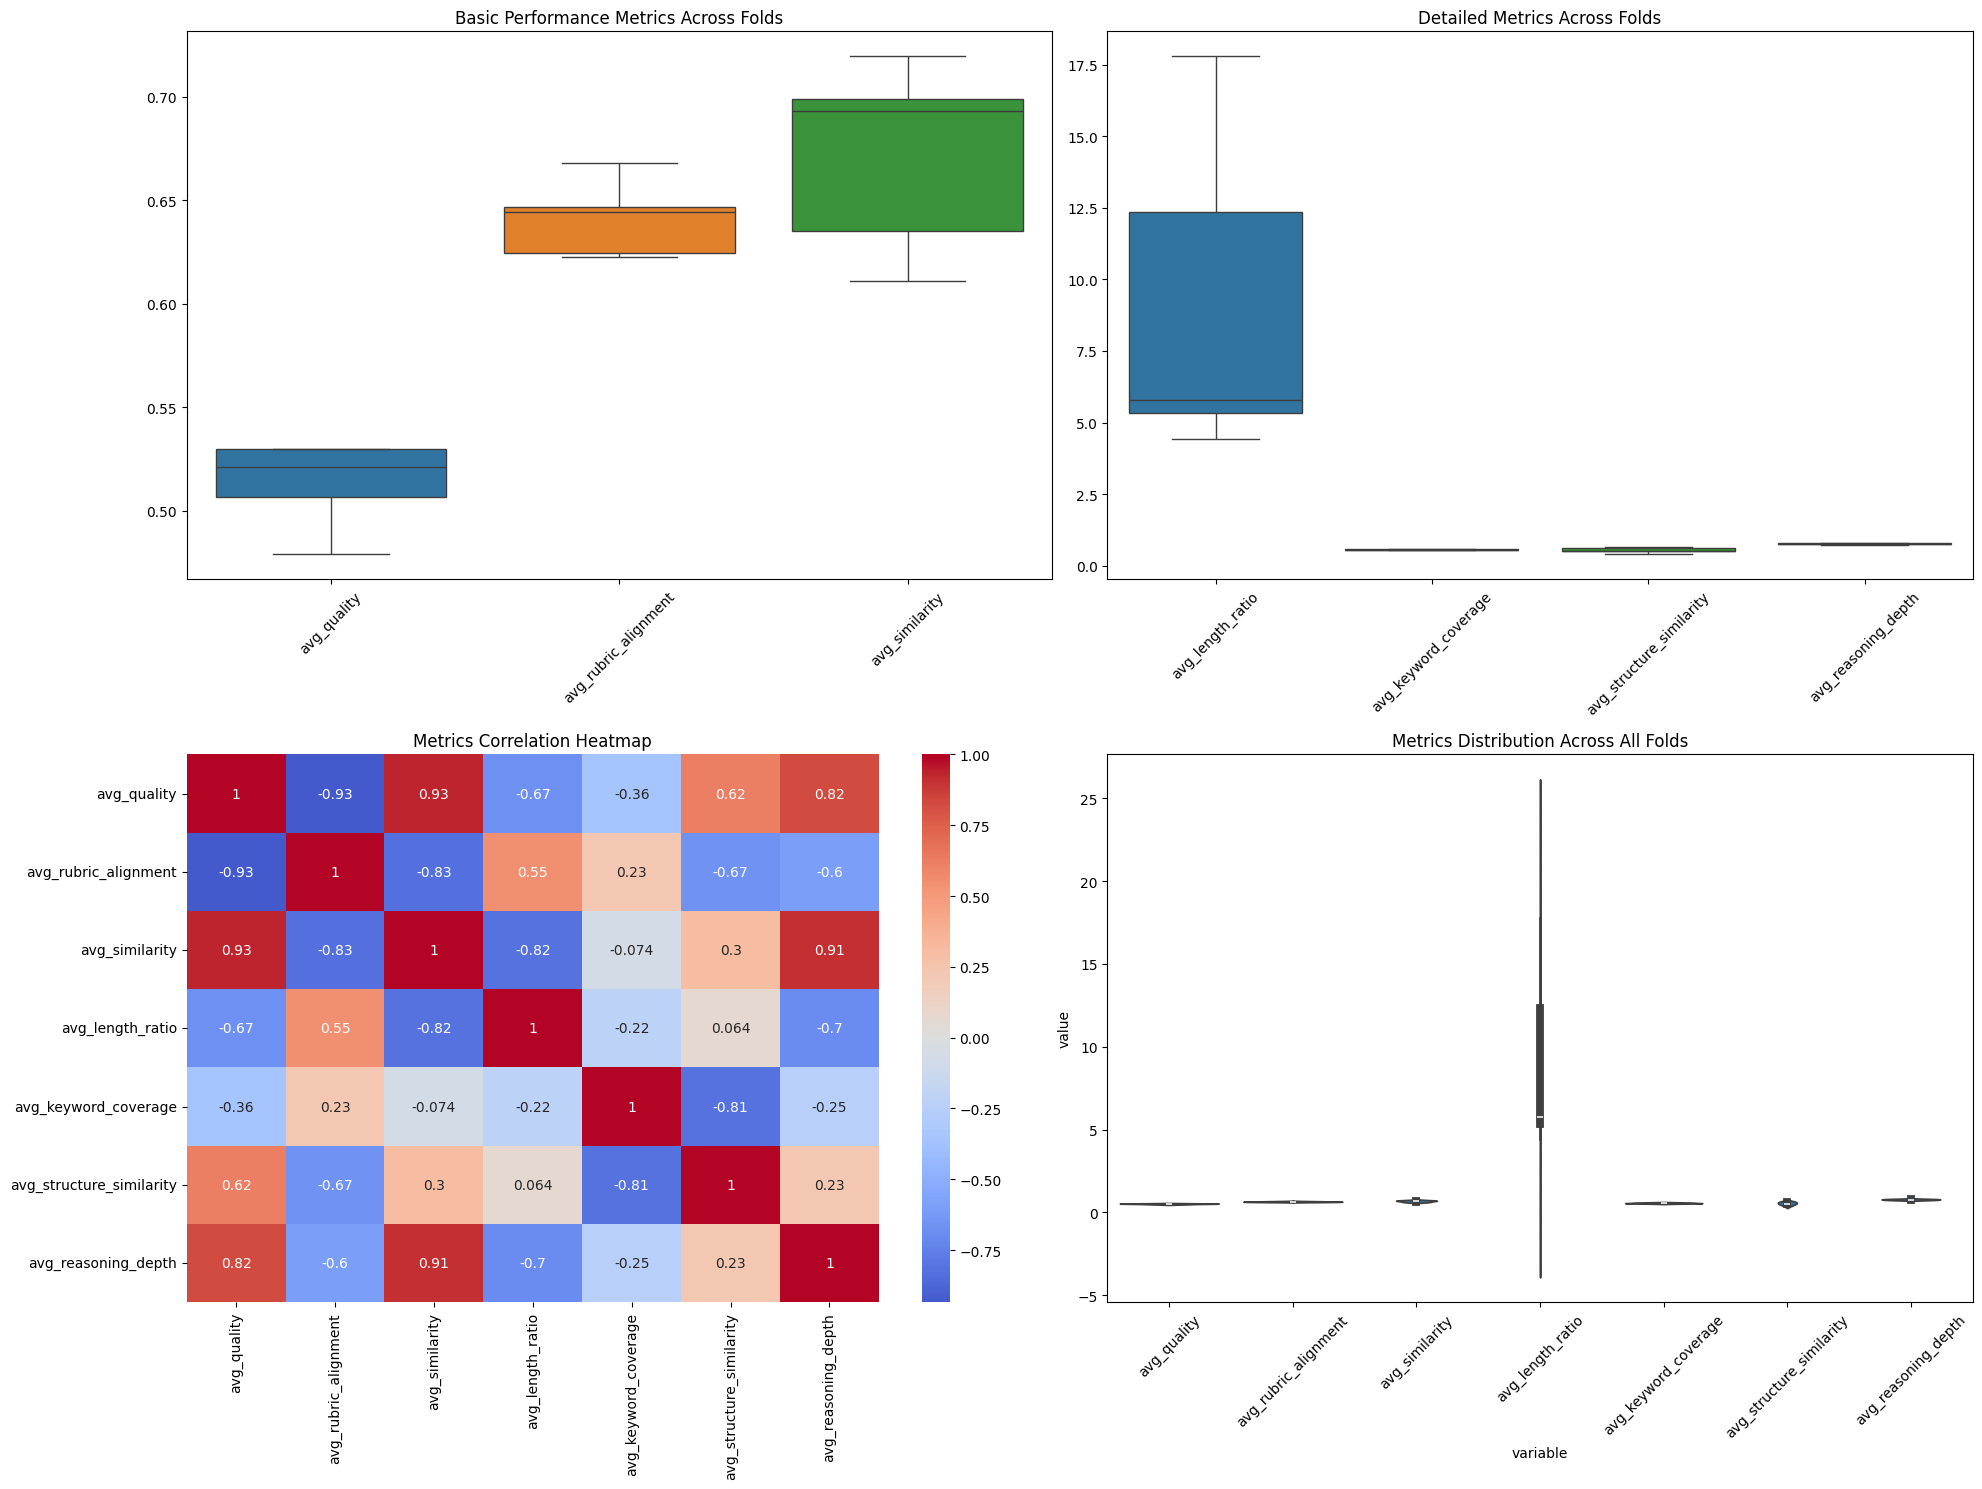

In [30]:
fig = plt.figure(figsize=(20, 15))

# 1. Basic Metrics Box Plot
plt.subplot(2, 2, 1)
basic_metrics = ['avg_quality', 'avg_rubric_alignment', 'avg_similarity']
fold_data = pd.DataFrame([fold['summary'] for fold in evaluation_results['fold_results']])
sns.boxplot(data=fold_data[basic_metrics])
plt.title('Basic Performance Metrics Across Folds')
plt.xticks(rotation=45)

# 2. Detailed Metrics Box Plot
plt.subplot(2, 2, 2)
detailed_metrics = ['avg_length_ratio', 'avg_keyword_coverage', 
                   'avg_structure_similarity', 'avg_reasoning_depth']
sns.boxplot(data=fold_data[detailed_metrics])
plt.title('Detailed Metrics Across Folds')
plt.xticks(rotation=45)

# 3. Metrics Correlation Heatmap
plt.subplot(2, 2, 3)
correlation_matrix = fold_data[[*basic_metrics, *detailed_metrics]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Metrics Correlation Heatmap')

# 4. Metrics Distribution Plot
plt.subplot(2, 2, 4)
metrics_long = pd.melt(fold_data[[*basic_metrics, *detailed_metrics]])
sns.violinplot(x='variable', y='value', data=metrics_long)
plt.title('Metrics Distribution Across All Folds')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


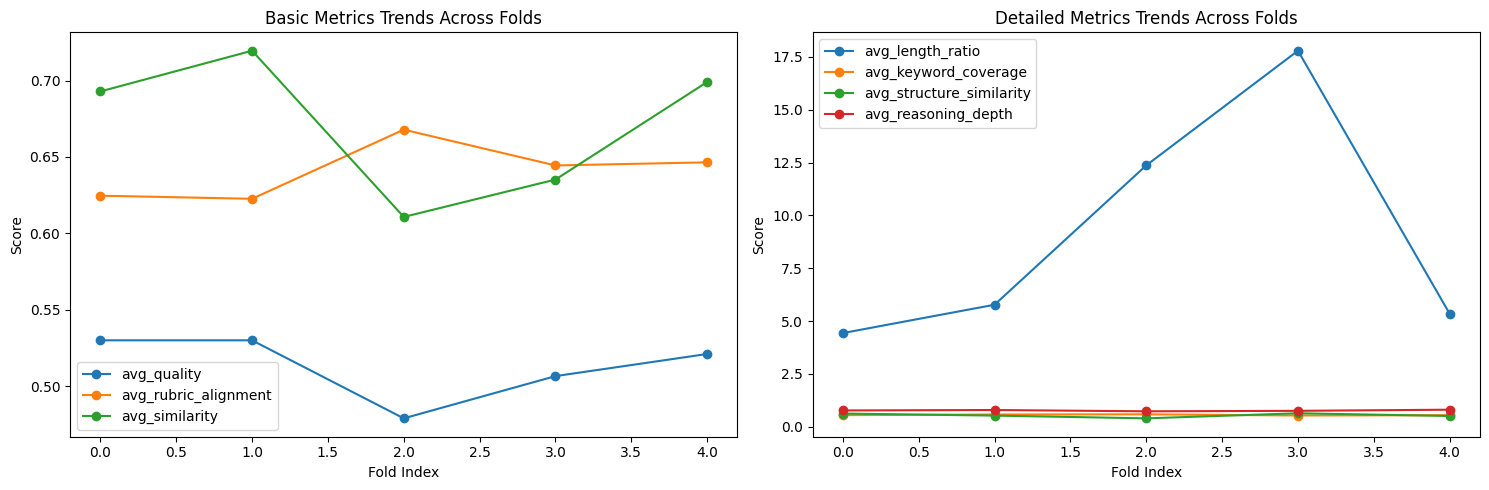

In [31]:
# Cross-fold Performance Trends
plt.figure(figsize=(15, 5))
fold_indices = range(len(evaluation_results['fold_results']))

# Basic Metrics Trends
plt.subplot(1, 2, 1)
for metric in basic_metrics:
    values = [fold['summary'][metric] for fold in evaluation_results['fold_results']]
    plt.plot(fold_indices, values, marker='o', label=metric)
plt.title('Basic Metrics Trends Across Folds')
plt.xlabel('Fold Index')
plt.ylabel('Score')
plt.legend()

# Detailed Metrics Trends
plt.subplot(1, 2, 2)
for metric in detailed_metrics:
    values = [fold['summary'][metric] for fold in evaluation_results['fold_results']]
    plt.plot(fold_indices, values, marker='o', label=metric)
plt.title('Detailed Metrics Trends Across Folds')
plt.xlabel('Fold Index')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()